In [63]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import torch

# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

In [3]:
df = pd.read_csv('data/European Restaurant Reviews.csv')

print(df.head())
print(df.info())
print(df.describe(include='all'))

  Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review Title Review Date  \
0                               Rude manager  May 2024 •   
1                       A big disappointment  Feb 2024 •   
2               Pretty Place with Bland Food  Nov 2023 •   
3   Great service and wine but inedible food  Mar 2023 •   
4  Avoid- Worst meal in Rome - possibly ever  Nov 2022 •   

                                              Review  
0  The manager became agressive when I said the c...  
1  I ordered a beef fillet ask to be done medium,...  
2  This is an attractive venue with welcoming, al...  
3  Sadly I  used the high TripAdvisor rating too ...  
4  From the start this meal was bad- especially g...  
<class '

In [4]:
num_observations = df.shape[0]
print(f'Number of observations: {num_observations}')

Number of observations: 1502


In [5]:
country_counts = df['Country'].value_counts()
most_represented_country = country_counts.idxmax()
most_represented_country_count = country_counts.max()
print(f'Most represented country: {most_represented_country} with {most_represented_country_count} reviews')

Most represented country: France with 512 reviews


In [9]:
df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')

min_date = df['Review Date'].min()
max_date = df['Review Date'].max()
print(f'Time range: {min_date} to {max_date}')

Time range: 2010-09-01 00:00:00 to 2010-09-01 00:00:00


In [16]:
restaurant_counts = df['Restaurant Name'].value_counts()
balanced_restaurants = restaurant_counts.value_counts().min() == restaurant_counts.value_counts().max()
print(f'The dataset is{"not" if not balanced_restaurants else ""} balanced in terms of restaurants')

The dataset is balanced in terms of restaurants


### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

In [18]:
def word_count(text):
    if pd.isna(text):
        return 0
    return len(text.split())

df['Word Count'] = df['Review'].apply(word_count)

average_word_count = df.groupby('Sentiment')['Word Count'].mean()
print(average_word_count)

print(f'Average word count for Positive reviews: {average_word_count["Positive"]}')
print(f'Average word count for Negative reviews: {average_word_count["Negative"]}')

Sentiment
Negative    140.573585
Positive     50.183508
Name: Word Count, dtype: float64
Average word count for Positive reviews: 50.18350848827809
Average word count for Negative reviews: 140.57358490566037



**Explanation**

On average, negative reviews have a significantly higher word count (140.57 words) compared to positive reviews (50.18 words). This suggests that negative reviews are more detailed or elaborate.

People may feel compelled to provide more details when describing their negative experiences. They might include more context, specific issues, or elaborate on what went wrong. (Or just spamming out of frustration, idk)

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

**Convert to Lowercase:**

Text should be converted to lowercase to ensure uniformity. This avoids treating the same word with different cases as distinct.aon)


In [20]:
df['Review'] = df['Review'].str.lower()

**Remove Punctuation:**

Punctuation marks do not contribute to sentiment analysis and should be removed.

In [21]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Review'] = df['Review'].apply(remove_punctuation)

**Remove Numbers:**

Numbers might not be relevant for sentiment analysis and can be removed.

In [22]:
def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

df['Review'] = df['Review'].apply(remove_numbers)

**Remove Extra Whitespace:**

Extra spaces should be trimmed to ensure clean text.

In [23]:
df['Review'] = df['Review'].str.strip()
df['Review'] = df['Review'].str.replace('\s+', ' ', regex=True)

##### Tokenization

**Objective:** Split text into individual words or tokens.

In [25]:
nltk.download('punkt')

df['Tokens'] = df['Review'].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deadh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


##### Stopword Removal
**Objective:** Remove common words that don’t contribute much to the sentiment, such as “the,” “is,” “and,” etc.

In [28]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['Tokens'] = df['Tokens'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deadh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


##### Stemming or Lemmatization
**Objective:** Reduce words to their base or root form to treat different forms of a word as the same entity.

- **Stemming:** Trims words to their base form but may sometimes cut off too aggressively.

In [30]:
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

df['Tokens'] = df['Tokens'].apply(stem_tokens)

- **Lemmatization:** More sophisticated and accurate than stemming as it considers the context of words.

In [33]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deadh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Handling Special Cases
**Objective:** Address domain-specific terms or special cases.

- **Handling Negations:** Negations can change the sentiment of the text and should be handled carefully.

In [35]:
def handle_negations(tokens):
    negations = {'not', 'no', 'never'}
    result = []
    skip = False
    for i, token in enumerate(tokens):
        if token in negations:
            skip = True
            continue
        if skip:
            result.append(token + '_NEG')
            skip = False
        else:
            result.append(token)
    return result

df['Tokens'] = df['Tokens'].apply(handle_negations)

##### Final Preprocessing
**Objective:** Ensure consistency and prepare data for model input.

In [37]:
df['Cleaned_Review'] = df['Tokens'].apply(lambda tokens: ' '.join(tokens))

df.to_csv('data/preprocessed_reviews.csv', index=False)

### Problem 3. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

1. Define "Top" Words
In this context, "top" words refer to the most frequently occurring words within each sentiment category (positive and negative reviews). We'll use word frequency counts to determine the top words.

2. Process
Here’s a structured approach to find and analyze the top 10 words for each sentiment category:

Step 1: Preprocess the Reviews
We should ensure that the reviews are preprocessed as described (cleaning, tokenization, stopword removal). 

Step 2: Tokenize and Count Words by Sentiment
Filter Reviews by Sentiment:

Separate the dataset into positive and negative reviews.
Tokenize the Reviews:

Tokenize the text of reviews into words.
Count Word Frequencies:

Count the frequency of each word in both positive and negative reviews.
Identify Top Words:

Extract the top 10 words based on their frequency.

Step 3: Implement the Steps in Code

Top 10 Words in Positive Reviews:
the: 3371
and: 2923
a: 1809
was: 1323
to: 1257
we: 1105
of: 1066
in: 835
is: 745
food: 734

Top 10 Words in Negative Reviews:
the: 2190
and: 1166
to: 932
was: 900
a: 871
we: 850
of: 653
i: 575
for: 534
in: 494


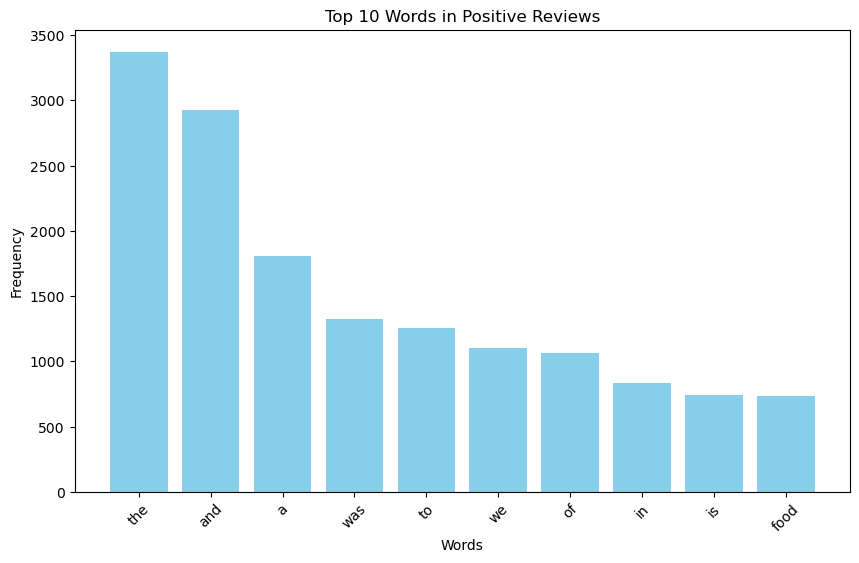

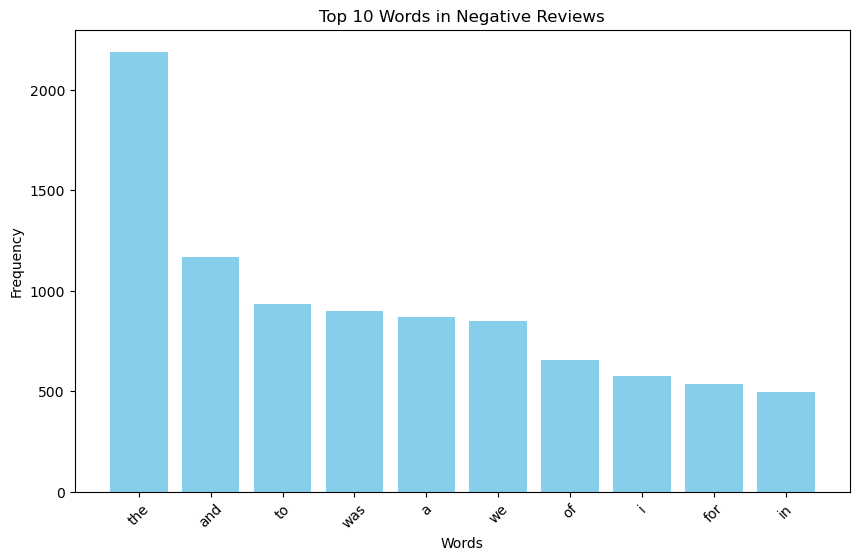

In [39]:
df['Review'] = df['Review'].str.lower()
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)
df['Review'] = df['Review'].str.replace('\d+', '', regex=True)
df['Tokens'] = df['Review'].apply(lambda x: x.split())  # Simple tokenization

positive_reviews = df[df['Sentiment'] == 'Positive']['Tokens']
negative_reviews = df[df['Sentiment'] == 'Negative']['Tokens']

def get_top_words(tokens_list, top_n=10):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    word_counts = Counter(all_tokens)
    return word_counts.most_common(top_n)

top_positive_words = get_top_words(positive_reviews)
top_negative_words = get_top_words(negative_reviews)

print("Top 10 Words in Positive Reviews:")
for word, count in top_positive_words:
    print(f"{word}: {count}")

print("\nTop 10 Words in Negative Reviews:")
for word, count in top_negative_words:
    print(f"{word}: {count}")

def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(top_positive_words, 'Top 10 Words in Positive Reviews')
plot_top_words(top_negative_words, 'Top 10 Words in Negative Reviews')

### Problem 4. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

In [42]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

df['Cleaned_Title'] = df['Review Title'].apply(preprocess_text)
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: word_tokenize(x))

def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

df['Title_Tokens_No_Stopwords'] = df['Title_Tokens'].apply(remove_stop_words)

def get_top_words(tokens_list, top_n=10):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    word_counts = Counter(all_tokens)
    return word_counts.most_common(top_n)

positive_titles = df[df['Sentiment'] == 'Positive']['Title_Tokens']
negative_titles = df[df['Sentiment'] == 'Negative']['Title_Tokens']

positive_titles_no_stopwords = df[df['Sentiment'] == 'Positive']['Title_Tokens_No_Stopwords']
negative_titles_no_stopwords = df[df['Sentiment'] == 'Negative']['Title_Tokens_No_Stopwords']

top_positive_words = get_top_words(positive_titles)
top_negative_words = get_top_words(negative_titles)

top_positive_words_no_stopwords = get_top_words(positive_titles_no_stopwords)
top_negative_words_no_stopwords = get_top_words(negative_titles_no_stopwords)

print("Top 10 Words in Positive Titles (With Stop Words):")
for word, count in top_positive_words:
    print(f"{word}: {count}")

print("\nTop 10 Words in Negative Titles (With Stop Words):")
for word, count in top_negative_words:
    print(f"{word}: {count}")

print("\nTop 10 Words in Positive Titles (Without Stop Words):")
for word, count in top_positive_words_no_stopwords:
    print(f"{word}: {count}")

print("\nTop 10 Words in Negative Titles (Without Stop Words):")
for word, count in top_negative_words_no_stopwords:
    print(f"{word}: {count}")

Top 10 Words in Positive Titles (With Stop Words):
great: 225
food: 176
and: 171
in: 113
a: 109
good: 105
place: 102
the: 96
service: 95
excellent: 78

Top 10 Words in Negative Titles (With Stop Words):
the: 36
food: 32
of: 32
and: 31
not: 28
service: 25
disappointing: 21
in: 20
a: 19
this: 18

Top 10 Words in Positive Titles (Without Stop Words):
great: 225
food: 176
good: 105
place: 102
service: 95
excellent: 78
best: 78
dinner: 74
restaurant: 72
amazing: 66

Top 10 Words in Negative Titles (Without Stop Words):
food: 32
service: 25
disappointing: 21
place: 16
bad: 15
rome: 14
great: 12
terrible: 12
restaurant: 11
ad: 11


### Problem 5. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

In [49]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d+', '', text) 
    return text

df['Cleaned_Title'] = df['Review Title'].apply(preprocess_text)
df['Cleaned_Review'] = df['Review'].apply(preprocess_text)
df['Title_Content'] = df['Cleaned_Title'] + ' ' + df['Cleaned_Review']

vectorizer_titles = CountVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    max_features=500,
    min_df=1,
    max_df=0.7
)

X_titles = vectorizer_titles.fit_transform(df['Cleaned_Title'])

print("Top features in Title Vectorizer:")
top_features_titles = vectorizer_titles.get_feature_names_out()
print(top_features_titles[:20])  

vectorizer_contents = CountVectorizer(
    ngram_range=(1, 3),
    stop_words='english',
    max_features=1000,
    min_df=5,
    max_df=0.5
)

X_contents = vectorizer_contents.fit_transform(df['Cleaned_Review'])

print("\nTop features in Content Vectorizer:")
top_features_contents = vectorizer_contents.get_feature_names_out()
print(top_features_contents[:20])  

vectorizer_combined = CountVectorizer(
    ngram_range=(1, 2),
    stop_words='english',
    max_features=1000,
    min_df=5,
    max_df=0.5
)

X_combined = vectorizer_combined.fit_transform(df['Title_Content'])

print("\nTop features in Combined Vectorizer:")
top_features_combined = vectorizer_combined.get_feature_names_out()
print(top_features_combined[:20])  

Top features in Title Vectorizer:
['abbie' 'absolutely' 'absolutely best' 'ad' 'ad hoc' 'affordable'
 'afternoon' 'aimane' 'albeit' 'albeit overpriced' 'amazing'
 'amazing dinner' 'amazing experience' 'amazing food' 'amazing place'
 'amazing restaurant' 'ambiance' 'ambience' 'american' 'anniversary']

Top features in Content Vectorizer:
['abbie' 'able' 'absolutely' 'accommodating' 'actually' 'ad' 'ad hoc'
 'ad hoc restaurant' 'add' 'added' 'advance' 'advisor' 'afternoon' 'ago'
 'alcohol' 'alek' 'amazing' 'amazing food' 'amazing service' 'ambiance']

Top features in Combined Vectorizer:
['abbie' 'able' 'absolutely' 'accommodating' 'actually' 'ad' 'ad hoc'
 'add' 'advance' 'advisor' 'afternoon' 'ago' 'alcohol' 'alek' 'amazing'
 'amazing experience' 'amazing food' 'amazing service' 'ambiance'
 'ambience']


### Problem 6. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

### Problem 7. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

### \* Problem 8. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.